# 위기 유형별 가맹점 분류 시스템

## 목표
- All Interval Features 모델을 활용하여 고위험 가맹점을 **5가지 위기 유형**으로 자동 분류
- 유형별 맞춤형 금융상품 및 개입 전략 제안
- SHAP 분석을 통한 유형별 위험 요인 파악

## 5가지 위기 유형
1. **매출 급락형**: 연속 하락 3개월 이상, 하락 속도 빠름
2. **고객 이탈형**: 재방문율 지속 하락, 신규 고객 유입 감소
3. **배달 의존형**: 배달 비율 증가 + 총 매출 감소
4. **경쟁 열위형**: 업종/상권 순위 지속 하락
5. **종합 위기형**: 매출+고객 동시 하락, 역대 최악 도달

## 1. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. 데이터 및 모델 로드

In [2]:
# 데이터 로드 (All Interval Features 포함)
data_path = Path('../data/processed/featured_data_with_intervals.csv')
df = pd.read_csv(data_path)

print(f"✅ Loaded data shape: {df.shape}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

✅ Loaded data shape: (86590, 148)
Date range: 202301 ~ 202412


In [3]:
# Interval feature 목록 로드
with open('../data/processed/interval_feature_list.json', 'r') as f:
    interval_features_info = json.load(f)

print(f"✅ Total interval features: {interval_features_info['total_features']}")
print(f"  - Decline features: {len(interval_features_info['decline_features'])}")
print(f"  - Historical worst features: {len(interval_features_info['historical_worst_features'])}")
print(f"  - Recovery features: {len(interval_features_info['recovery_features'])}")
print(f"  - Cross-metric features: {len(interval_features_info['cross_metric_features'])}")

✅ Total interval features: 142
  - Decline features: 47
  - Historical worst features: 20
  - Recovery features: 28
  - Cross-metric features: 9


In [4]:
# 모델 및 Feature 목록 로드
model_dir = Path('../models')

# XGBoost All Interval Features 모델
with open(model_dir / 'xgboost_best.pkl', 'rb') as f:
    model = pickle.load(f)
print("✅ Model loaded: XGBoost (All Interval Features)")

# Feature 목록
with open(model_dir / 'feature_cols.pkl', 'rb') as f:
    feature_cols = pickle.load(f)
print(f"✅ Feature columns: {len(feature_cols)}")

# 모델 성능 확인
with open(model_dir / 'final_results.json', 'r') as f:
    results = json.load(f)

print(f"\nModel Performance (Test Set):")
print(f"  ROC-AUC: {results['test_roc_auc']:.4f}")
print(f"  PR-AUC: {results['test_pr_auc']:.4f}")
print(f"  Recall: {results['test_recall']:.4f}")
print(f"  Precision: {results['test_precision']:.4f}")

✅ Model loaded: XGBoost (All Interval Features)
✅ Feature columns: 134

Model Performance (Test Set):
  ROC-AUC: 0.6980
  PR-AUC: 0.0261
  Recall: 0.1818
  Precision: 0.0071


## 3. 최신 데이터 필터링 및 위험도 예측

In [5]:
# 최신 월 데이터 (202412)
latest_month = df['TA_YM'].max()
print(f"Latest month: {latest_month}")

df_latest = df[df['TA_YM'] == latest_month].copy()
print(f"\nTotal merchants in {latest_month}: {len(df_latest):,}")

# 영업 중인 가맹점만 필터링 (폐업일이 없는 가맹점)
df_active = df_latest[df_latest['MCT_ME_D'].isna()].copy()
print(f"Active merchants: {len(df_active):,}")
print(f"Closed merchants: {len(df_latest) - len(df_active):,}")

Latest month: 202412

Total merchants in 202412: 4,155
Active merchants: 4,058
Closed merchants: 97


In [6]:
# Feature 준비
X_active = df_active[feature_cols].copy()

# 결측값 처리 (중앙값 대체)
X_active = X_active.fillna(X_active.median())

print(f"Prediction features shape: {X_active.shape}")
print(f"Missing values: {X_active.isnull().sum().sum()}")

Prediction features shape: (4058, 134)
Missing values: 0


In [7]:
# 폐업 확률 예측
closure_probabilities = model.predict_proba(X_active)[:, 1]

# 결과 DataFrame 생성
df_risk = df_active[['ENCODED_MCT', 'TA_YM', 'HPSN_MCT_BZN_CD_NM']].copy()
df_risk['closure_probability'] = closure_probabilities
df_risk['risk_score'] = (closure_probabilities * 100).astype(int)

# 위험도 등급
def get_risk_level(score):
    if score >= 80: return 'Very High'
    elif score >= 60: return 'High'
    elif score >= 40: return 'Medium'
    elif score >= 20: return 'Low'
    else: return 'Very Low'

df_risk['risk_level'] = df_risk['risk_score'].apply(get_risk_level)

print("✅ Prediction completed")
print(f"\nRisk Score Statistics:")
print(df_risk['risk_score'].describe())
print(f"\nRisk Level Distribution:")
print(df_risk['risk_level'].value_counts())

✅ Prediction completed

Risk Score Statistics:
count    4058.000000
mean        7.747413
std        11.319808
min         0.000000
25%         1.000000
50%         3.000000
75%         9.000000
max        84.000000
Name: risk_score, dtype: float64

Risk Level Distribution:
risk_level
Very Low     3566
Low           356
Medium        119
High           14
Very High       3
Name: count, dtype: int64


## 4. 위기 유형 자동 분류 시스템 🎯

### Interval Pattern Features 기반 분류 로직

In [8]:
def classify_risk_type(merchant_idx):
    """
    Interval Pattern Features 기반 위기 유형 자동 분류
    
    Returns:
        risk_type (str): 위기 유형
        priority (str): 우선순위 (critical/urgent/important/watch/normal)
        confidence (float): 분류 신뢰도 (0-1)
    """
    row = X_active.loc[merchant_idx]
    
    # Helper functions
    def safe_get(col, default=0):
        """안전하게 컬럼 값 가져오기"""
        return row.get(col, default) if col in row.index else default
    
    # 각 유형별 점수 계산 (0-100)
    scores = {
        '종합 위기형': 0,
        '매출 급락형': 0,
        '고객 이탈형': 0,
        '배달 의존형': 0,
        '경쟁 열위형': 0
    }
    
    # ========== 1. 종합 위기형 (가장 치명적) ==========
    # 조건: 매출+고객 동시 하락 + 여러 지표 역대 최악
    if safe_get('aligned_decline_RC_M1_SAA_RC_M1_UE_CUS_CN') == 1:
        scores['종합 위기형'] += 40
    
    # 역대 최악 도달 (여러 지표)
    at_worst_count = (
        safe_get('RC_M1_SAA_at_worst_now') +
        safe_get('RC_M1_UE_CUS_CN_at_worst_now') +
        safe_get('RC_M1_TO_UE_CT_at_worst_now')
    )
    scores['종합 위기형'] += min(at_worst_count * 15, 45)
    
    # 장기 연속 하락
    if safe_get('RC_M1_SAA_consecutive_declines') >= 4:
        scores['종합 위기형'] += 15
    
    # ========== 2. 매출 급락형 ==========
    # 조건: 연속 하락 3개월 이상 + 하락 속도 빠름
    consecutive_decline = safe_get('RC_M1_SAA_consecutive_declines')
    if consecutive_decline >= 3:
        scores['매출 급락형'] += min(consecutive_decline * 10, 40)
    
    decline_speed = safe_get('RC_M1_SAA_decline_speed_3m')
    if decline_speed > 1.0:
        scores['매출 급락형'] += min(decline_speed * 20, 40)
    
    # 역대 최악 도달
    if safe_get('RC_M1_SAA_at_worst_now') == 1:
        scores['매출 급락형'] += 20
    
    # ========== 3. 고객 이탈형 ==========
    # 조건: 고객 수 지속 감소 + 재방문율 하락
    customer_decline = safe_get('RC_M1_UE_CUS_CN_consecutive_declines')
    if customer_decline >= 3:
        scores['고객 이탈형'] += min(customer_decline * 15, 50)
    
    # 재방문율 하락 (원본 feature 활용)
    if 'MCT_UE_CLN_REU_RAT' in row.index:
        reuse_rate = safe_get('MCT_UE_CLN_REU_RAT')
        if reuse_rate < 30:  # 재방문율 30% 미만
            scores['고객 이탈형'] += 30
    
    # 고객 수 역대 최악
    if safe_get('RC_M1_UE_CUS_CN_at_worst_now') == 1:
        scores['고객 이탈형'] += 20
    
    # ========== 4. 배달 의존형 ==========
    # 조건: 배달 비율 높음 + 전체 매출 하락
    delivery_ratio = safe_get('DLV_SAA_RAT')
    if delivery_ratio > 60:
        scores['배달 의존형'] += min((delivery_ratio - 60) * 2, 50)
    
    # 전체 매출 하락
    if safe_get('RC_M1_SAA_is_declining') == 1:
        scores['배달 의존형'] += 30
    
    # 객단가 하락
    if safe_get('RC_M1_AV_NP_AT_consecutive_declines') >= 2:
        scores['배달 의존형'] += 20
    
    # ========== 5. 경쟁 열위형 ==========
    # 조건: 업종/상권 순위 하락 + 최고 성과 대비 큰 하락
    distance_from_best = safe_get('RC_M1_SAA_distance_from_best')
    if distance_from_best >= 3:
        scores['경쟁 열위형'] += min(distance_from_best * 15, 60)
    
    # 최고 성과 이후 장기간 경과
    months_since_best = safe_get('RC_M1_SAA_months_since_best')
    if months_since_best >= 12:
        scores['경쟁 열위형'] += 20
    
    # 업종 순위 하락 (원본 feature)
    if 'M12_SME_RY_SAA_PCE_RT' in row.index:
        industry_rank = safe_get('M12_SME_RY_SAA_PCE_RT')
        if industry_rank > 75:  # 하위 25%
            scores['경쟁 열위형'] += 20
    
    # ========== 최종 분류 ==========
    # 가장 높은 점수의 유형 선택
    risk_type = max(scores, key=scores.get)
    max_score = scores[risk_type]
    confidence = min(max_score / 100, 1.0)
    
    # 점수가 낮으면 '기타 위험'으로 분류
    if max_score < 30:
        risk_type = '기타 위험'
        confidence = 0.0
    
    # 우선순위 결정
    priority_map = {
        '종합 위기형': 'critical',
        '매출 급락형': 'urgent',
        '고객 이탈형': 'important',
        '배달 의존형': 'watch',
        '경쟁 열위형': 'watch',
        '기타 위험': 'normal'
    }
    priority = priority_map[risk_type]
    
    return risk_type, priority, confidence, scores

print("✅ Risk classification function defined")

✅ Risk classification function defined


In [9]:
# 고위험 가맹점 위기 유형 분류 (risk_score >= 60만)
print("Classifying risk types for HIGH-RISK merchants only (risk_score >= 60)...")
print(f"Total merchants: {len(df_risk):,}")
print(f"High-risk merchants (score >= 60): {(df_risk['risk_score'] >= 60).sum():,}")

risk_types = []
priorities = []
confidences = []
all_scores = []

for idx in df_risk.index:
    risk_score = df_risk.loc[idx, 'risk_score']
    
    # 고위험 가맹점만 위기 유형 분류
    if risk_score >= 60:
        risk_type, priority, confidence, scores = classify_risk_type(idx)
        risk_types.append(risk_type)
        priorities.append(priority)
        confidences.append(confidence)
        all_scores.append(scores)
    else:
        # 저위험/중위험 가맹점은 '정상'으로 분류
        risk_types.append('정상')
        priorities.append('normal')
        confidences.append(0.0)
        all_scores.append({})

df_risk['risk_type'] = risk_types
df_risk['priority'] = priorities
df_risk['classification_confidence'] = confidences

print("✅ Risk type classification completed")
print(f"\nRisk Type Distribution:")
print(df_risk['risk_type'].value_counts())
print(f"\nHigh-Risk Type Breakdown (excluding '정상'):")
high_risk_types = df_risk[df_risk['risk_type'] != '정상']['risk_type'].value_counts()
if len(high_risk_types) > 0:
    print(high_risk_types)

Classifying risk types for HIGH-RISK merchants only (risk_score >= 60)...
Total merchants: 4,058
High-risk merchants (score >= 60): 17
✅ Risk type classification completed

Risk Type Distribution:
risk_type
정상        4041
고객 이탈형      10
배달 의존형       3
종합 위기형       3
기타 위험        1
Name: count, dtype: int64

High-Risk Type Breakdown (excluding '정상'):
risk_type
고객 이탈형    10
배달 의존형     3
종합 위기형     3
기타 위험      1
Name: count, dtype: int64


## 5. 유형별 통계 분석

In [10]:
# 유형별 기본 통계
risk_type_stats = df_risk.groupby('risk_type').agg({
    'ENCODED_MCT': 'count',
    'risk_score': ['mean', 'median', 'std', 'min', 'max'],
    'closure_probability': ['mean', 'median'],
    'classification_confidence': 'mean'
}).round(2)

risk_type_stats.columns = ['_'.join(col).strip() for col in risk_type_stats.columns.values]
risk_type_stats = risk_type_stats.rename(columns={'ENCODED_MCT_count': 'merchant_count'})

print("Risk Type Statistics:")
print("=" * 100)
display(risk_type_stats.sort_values('risk_score_mean', ascending=False))

Risk Type Statistics:


,merchant_count,risk_score_mean,risk_score_median,risk_score_std,risk_score_min,risk_score_max,closure_probability_mean,closure_probability_median,classification_confidence_mean
risk_type,,,,,,,,,
기타 위험,1,81.00,81.0,NaN,81,81,0.81,0.81,0.00
고객 이탈형,10,69.50,68.5,7.59,61,84,0.70,0.69,0.46
배달 의존형,3,67.67,68.0,1.53,66,69,0.68,0.69,0.47
종합 위기형,3,63.33,61.0,4.93,60,69,0.64,0.61,0.67
정상,4041,7.49,3.0,10.62,0,57,0.08,0.03,0.00


In [11]:
# 우선순위별 분포
priority_dist = df_risk.groupby('priority').agg({
    'ENCODED_MCT': 'count',
    'risk_score': 'mean'
}).round(2)
priority_dist.columns = ['merchant_count', 'avg_risk_score']

print("\nPriority Distribution:")
print("=" * 60)
priority_order = ['critical', 'urgent', 'important', 'watch', 'normal']
priority_dist = priority_dist.reindex(priority_order)
display(priority_dist)


Priority Distribution:


,merchant_count,avg_risk_score
priority,,
critical,3.0,63.33
urgent,NaN,NaN
important,10.0,69.50
watch,3.0,67.67
normal,4042.0,7.51


## 6. 유형별 맞춤형 솔루션 매칭

In [12]:
# 유형별 솔루션 정의
risk_solution_map = {
    '종합 위기형': {
        'solutions': [
            '긴급 안정화 패키지 (운영자금 + 컨설팅)',
            '구조조정 지원 (경영 진단 + 전략 수립)',
            '신용보증 특별 지원',
            '우선 관리 대상 지정'
        ],
        'priority': 'critical',
        'priority_kr': '최우선 긴급',
        'estimated_recovery_period': '6-12개월',
        'intervention_timing': '즉시',
        'success_rate': '30-40%',
        'description': '여러 지표가 동시에 최악 상태. 즉각적이고 강력한 개입 필요'
    },
    '매출 급락형': {
        'solutions': [
            '단기 운영자금 대출 (저금리)',
            '경영 컨설팅 (매출 분석 + 개선)',
            '마케팅 지원 프로그램',
            '업종 전환 컨설팅'
        ],
        'priority': 'urgent',
        'priority_kr': '긴급',
        'estimated_recovery_period': '3-6개월',
        'intervention_timing': '1주 이내',
        'success_rate': '50-60%',
        'description': '급격한 매출 하락. 빠른 원인 파악과 대응 전략 수립 필요'
    },
    '고객 이탈형': {
        'solutions': [
            '고객 리텐션 프로그램 지원',
            '마케팅 지원 대출',
            '고객 데이터 분석 서비스',
            '재방문 캠페인 기획 지원'
        ],
        'priority': 'important',
        'priority_kr': '중요',
        'estimated_recovery_period': '6-9개월',
        'intervention_timing': '2주 이내',
        'success_rate': '60-70%',
        'description': '고객 이탈 가속화. 고객 관계 회복 및 신규 유치 전략 필요'
    },
    '배달 의존형': {
        'solutions': [
            '오프라인 경쟁력 강화 프로그램',
            '상권 분석 및 재포지셔닝',
            '매장 리뉴얼 지원',
            '배달 수수료 최적화 컨설팅'
        ],
        'priority': 'watch',
        'priority_kr': '관찰 필요',
        'estimated_recovery_period': '9-12개월',
        'intervention_timing': '1개월 이내',
        'success_rate': '50-60%',
        'description': '배달 과의존으로 수익성 악화. 오프라인 강화 및 수익 구조 개선 필요'
    },
    '경쟁 열위형': {
        'solutions': [
            '경쟁력 강화 패키지',
            '차별화 전략 수립 컨설팅',
            '업종/상권 분석 서비스',
            '메뉴 개발 및 품질 개선 지원'
        ],
        'priority': 'watch',
        'priority_kr': '관찰 필요',
        'estimated_recovery_period': '6-12개월',
        'intervention_timing': '1개월 이내',
        'success_rate': '40-50%',
        'description': '시장 내 경쟁력 약화. 차별화 및 포지셔닝 재정립 필요'
    },
    '정상': {
        'solutions': [
            '정기 모니터링',
            '예방적 경영 진단',
            '우수 경영 사례 공유',
            '장기 성장 지원 프로그램'
        ],
        'priority': 'normal',
        'priority_kr': '정상',
        'estimated_recovery_period': 'N/A',
        'intervention_timing': '정기 점검',
        'success_rate': 'N/A',
        'description': '위험도 낮음 (risk_score < 60). 정기 모니터링 및 예방적 관리'
    },
    '기타 위험': {
        'solutions': [
            '정기 모니터링',
            '예방적 경영 진단',
            '업종별 리스크 교육'
        ],
        'priority': 'normal',
        'priority_kr': '기타',
        'estimated_recovery_period': 'N/A',
        'intervention_timing': '정기 점검',
        'success_rate': 'N/A',
        'description': '고위험이지만 명확한 위험 패턴 미감지. 정기 모니터링 지속'
    }
}

# DataFrame으로 변환
solution_df = pd.DataFrame(risk_solution_map).T
solution_df['solutions_text'] = solution_df['solutions'].apply(lambda x: '\n'.join([f'{i+1}. {s}' for i, s in enumerate(x)]))

print("✅ Risk solutions mapped")
print("\nRisk Type Solutions:")
print("=" * 100)
for risk_type, info in risk_solution_map.items():
    count = (df_risk['risk_type'] == risk_type).sum()
    print(f"\n[{risk_type}] ({count:,} 가맹점) - {info['priority_kr']}")
    print(f"  {info['description']}")
    print(f"  회복 기간: {info['estimated_recovery_period']} | 개입 시점: {info['intervention_timing']} | 성공률: {info['success_rate']}")
    print(f"  솔루션:")
    for i, sol in enumerate(info['solutions'], 1):
        print(f"    {i}. {sol}")

✅ Risk solutions mapped

Risk Type Solutions:

[종합 위기형] (3 가맹점) - 최우선 긴급
  여러 지표가 동시에 최악 상태. 즉각적이고 강력한 개입 필요
  회복 기간: 6-12개월 | 개입 시점: 즉시 | 성공률: 30-40%
  솔루션:
    1. 긴급 안정화 패키지 (운영자금 + 컨설팅)
    2. 구조조정 지원 (경영 진단 + 전략 수립)
    3. 신용보증 특별 지원
    4. 우선 관리 대상 지정

[매출 급락형] (0 가맹점) - 긴급
  급격한 매출 하락. 빠른 원인 파악과 대응 전략 수립 필요
  회복 기간: 3-6개월 | 개입 시점: 1주 이내 | 성공률: 50-60%
  솔루션:
    1. 단기 운영자금 대출 (저금리)
    2. 경영 컨설팅 (매출 분석 + 개선)
    3. 마케팅 지원 프로그램
    4. 업종 전환 컨설팅

[고객 이탈형] (10 가맹점) - 중요
  고객 이탈 가속화. 고객 관계 회복 및 신규 유치 전략 필요
  회복 기간: 6-9개월 | 개입 시점: 2주 이내 | 성공률: 60-70%
  솔루션:
    1. 고객 리텐션 프로그램 지원
    2. 마케팅 지원 대출
    3. 고객 데이터 분석 서비스
    4. 재방문 캠페인 기획 지원

[배달 의존형] (3 가맹점) - 관찰 필요
  배달 과의존으로 수익성 악화. 오프라인 강화 및 수익 구조 개선 필요
  회복 기간: 9-12개월 | 개입 시점: 1개월 이내 | 성공률: 50-60%
  솔루션:
    1. 오프라인 경쟁력 강화 프로그램
    2. 상권 분석 및 재포지셔닝
    3. 매장 리뉴얼 지원
    4. 배달 수수료 최적화 컨설팅

[경쟁 열위형] (0 가맹점) - 관찰 필요
  시장 내 경쟁력 약화. 차별화 및 포지셔닝 재정립 필요
  회복 기간: 6-12개월 | 개입 시점: 1개월 이내 | 성공률: 40-50%
  솔루션:
    1. 경쟁력 강화 패키지
    2. 차별화 전략 수립 컨설팅


## 7. 고위험 가맹점 상세 분석

In [13]:
# 고위험 가맹점 (risk_score >= 60)
high_risk = df_risk[df_risk['risk_score'] >= 60].copy()
high_risk = high_risk.sort_values('risk_score', ascending=False)

print(f"High Risk Merchants (score >= 60): {len(high_risk):,}")
print(f"\nRisk Type Breakdown:")
print(high_risk['risk_type'].value_counts())

print(f"\nTop 20 Highest Risk Merchants:")
print("=" * 100)
display(high_risk[[
    'ENCODED_MCT', 'HPSN_MCT_BZN_CD_NM', 'risk_score', 'risk_type', 
    'priority', 'classification_confidence'
]].head(20))

High Risk Merchants (score >= 60): 17

Risk Type Breakdown:
risk_type
고객 이탈형    10
종합 위기형     3
배달 의존형     3
기타 위험      1
Name: count, dtype: int64

Top 20 Highest Risk Merchants:


,ENCODED_MCT,HPSN_MCT_BZN_CD_NM,risk_score,risk_type,priority,classification_confidence
9119,1A9644F28E,NaN,84,고객 이탈형,important,0.500
2413,06A87DAA45,뚝섬,81,기타 위험,normal,0.000
13109,259546987D,왕십리,80,고객 이탈형,important,0.500
74340,DD45EECEE3,NaN,72,고객 이탈형,important,0.500
41811,790D3285E3,NaN,69,고객 이탈형,important,0.300
64961,BF88DF05E7,왕십리,69,종합 위기형,critical,0.850
67137,C56839C38F,뚝섬,69,고객 이탈형,important,0.500
50176,932F4562E9,왕십리,69,배달 의존형,watch,0.500
3913,0B36DDFB1B,왕십리,68,고객 이탈형,important,0.500
50692,94795C00AE,성수,68,고객 이탈형,important,0.500


In [14]:
# 유형별 샘플 가맹점 분석 (고위험 유형만)
print("Sample Merchants by Risk Type (High-Risk Only):")
print("=" * 100)

for risk_type in ['종합 위기형', '매출 급락형', '고객 이탈형', '배달 의존형', '경쟁 열위형']:
    type_merchants = df_risk[df_risk['risk_type'] == risk_type].sort_values('risk_score', ascending=False)
    
    if len(type_merchants) > 0:
        print(f"\n[{risk_type}] Top 3 Merchants:")
        print("-" * 100)
        
        for i, (idx, row) in enumerate(type_merchants.head(3).iterrows(), 1):
            merchant_id = row['ENCODED_MCT']
            category = row['HPSN_MCT_BZN_CD_NM']
            risk_score = row['risk_score']
            confidence = row['classification_confidence']
            
            print(f"{i}. {merchant_id} | {category} | Risk: {risk_score} | Confidence: {confidence:.2f}")
            
            # 주요 지표 출력
            merchant_features = X_active.loc[idx]
            
            if risk_type == '매출 급락형':
                decline = merchant_features.get('RC_M1_SAA_consecutive_declines', 0)
                speed = merchant_features.get('RC_M1_SAA_decline_speed_3m', 0)
                print(f"   연속 하락: {decline:.0f}개월 | 하락 속도: {speed:.2f}")
            
            elif risk_type == '고객 이탈형':
                cust_decline = merchant_features.get('RC_M1_UE_CUS_CN_consecutive_declines', 0)
                reuse = merchant_features.get('MCT_UE_CLN_REU_RAT', 0)
                print(f"   고객 연속 하락: {cust_decline:.0f}개월 | 재방문율: {reuse:.1f}%")
            
            elif risk_type == '배달 의존형':
                delivery = merchant_features.get('DLV_SAA_RAT', 0)
                declining = merchant_features.get('RC_M1_SAA_is_declining', 0)
                print(f"   배달 비율: {delivery:.1f}% | 매출 하락 중: {'예' if declining else '아니오'}")
            
            elif risk_type == '경쟁 열위형':
                distance = merchant_features.get('RC_M1_SAA_distance_from_best', 0)
                months = merchant_features.get('RC_M1_SAA_months_since_best', 0)
                print(f"   최고점 대비 하락: {distance:.0f}단계 | 최고 이후: {months:.0f}개월")
            
            elif risk_type == '종합 위기형':
                aligned = merchant_features.get('aligned_decline_RC_M1_SAA_RC_M1_UE_CUS_CN', 0)
                at_worst_sales = merchant_features.get('RC_M1_SAA_at_worst_now', 0)
                at_worst_cust = merchant_features.get('RC_M1_UE_CUS_CN_at_worst_now', 0)
                print(f"   동시 하락: {'예' if aligned else '아니오'} | 매출 최악: {'예' if at_worst_sales else '아니오'} | 고객 최악: {'예' if at_worst_cust else '아니오'}")
    else:
        print(f"\n[{risk_type}] No merchants classified")

# 정상 가맹점 통계
normal_count = (df_risk['risk_type'] == '정상').sum()
print(f"\n\n[정상] {normal_count:,} 가맹점")
print("  위험도 낮음 (risk_score < 60). 정기 모니터링 및 예방적 관리")

Sample Merchants by Risk Type (High-Risk Only):

[종합 위기형] Top 3 Merchants:
----------------------------------------------------------------------------------------------------
1. BF88DF05E7 | 왕십리 | Risk: 69 | Confidence: 0.85
   동시 하락: 예 | 매출 최악: 예 | 고객 최악: 예
2. DD4FCA5BE6 | nan | Risk: 61 | Confidence: 0.30
   동시 하락: 아니오 | 매출 최악: 아니오 | 고객 최악: 예
3. F7E9A69F8D | nan | Risk: 60 | Confidence: 0.85
   동시 하락: 예 | 매출 최악: 예 | 고객 최악: 예

[매출 급락형] No merchants classified

[고객 이탈형] Top 3 Merchants:
----------------------------------------------------------------------------------------------------
1. 1A9644F28E | nan | Risk: 84 | Confidence: 0.50
   고객 연속 하락: 0개월 | 재방문율: 24.4%
2. 259546987D | 왕십리 | Risk: 80 | Confidence: 0.50
   고객 연속 하락: 0개월 | 재방문율: 24.4%
3. DD45EECEE3 | nan | Risk: 72 | Confidence: 0.50
   고객 연속 하락: 0개월 | 재방문율: 20.1%

[배달 의존형] Top 3 Merchants:
----------------------------------------------------------------------------------------------------
1. 932F4562E9 | 왕십리 | Risk: 69 | Co

## 8. 시각화

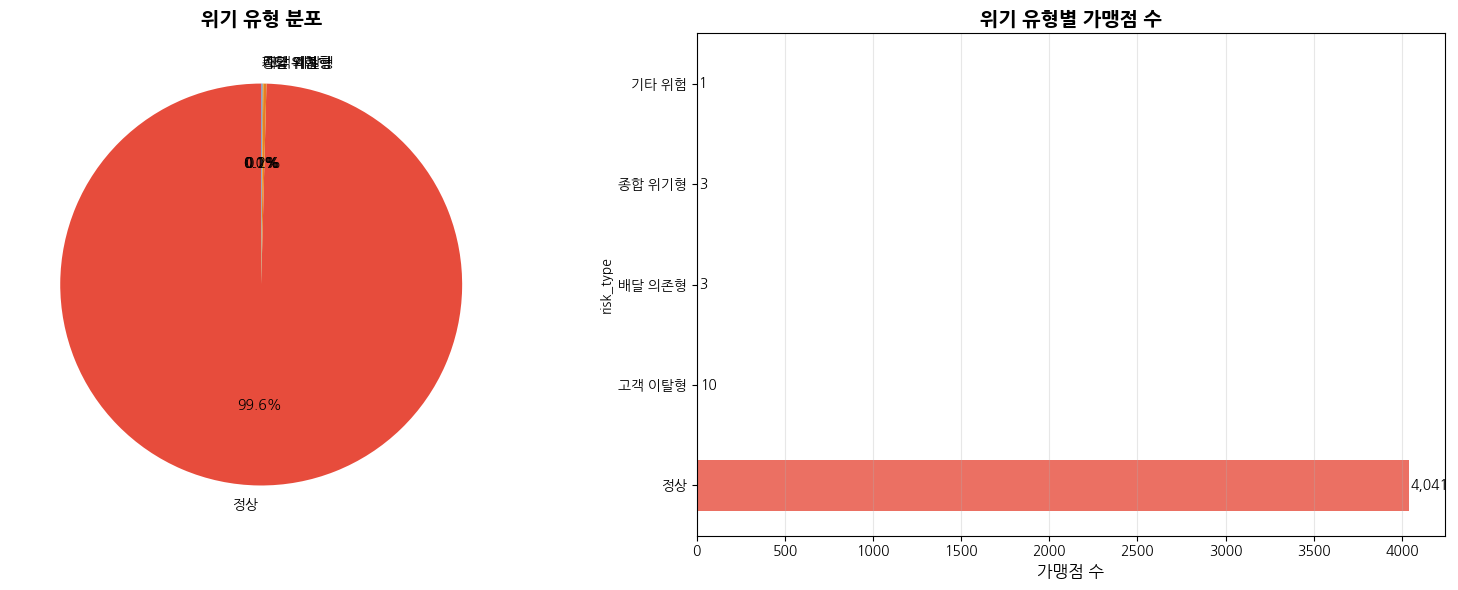

✅ Saved: ../results/risk_type_distribution.png


In [15]:
# 출력 디렉토리 생성 (시각화 저장용)
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)

# 시각화 1: 위기 유형 분포
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
risk_type_counts = df_risk['risk_type'].value_counts()
colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#9b59b6', '#95a5a6']
axes[0].pie(risk_type_counts, labels=risk_type_counts.index, autopct='%1.1f%%',
            colors=colors[:len(risk_type_counts)], startangle=90)
axes[0].set_title('위기 유형 분포', fontsize=14, fontweight='bold')

# Bar chart
risk_type_counts.plot(kind='barh', ax=axes[1], color=colors[:len(risk_type_counts)], alpha=0.8)
axes[1].set_xlabel('가맹점 수', fontsize=12)
axes[1].set_title('위기 유형별 가맹점 수', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(risk_type_counts):
    axes[1].text(v + 10, i, f'{v:,}', va='center')

plt.tight_layout()
plt.savefig(output_dir / 'risk_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {output_dir / 'risk_type_distribution.png'}")

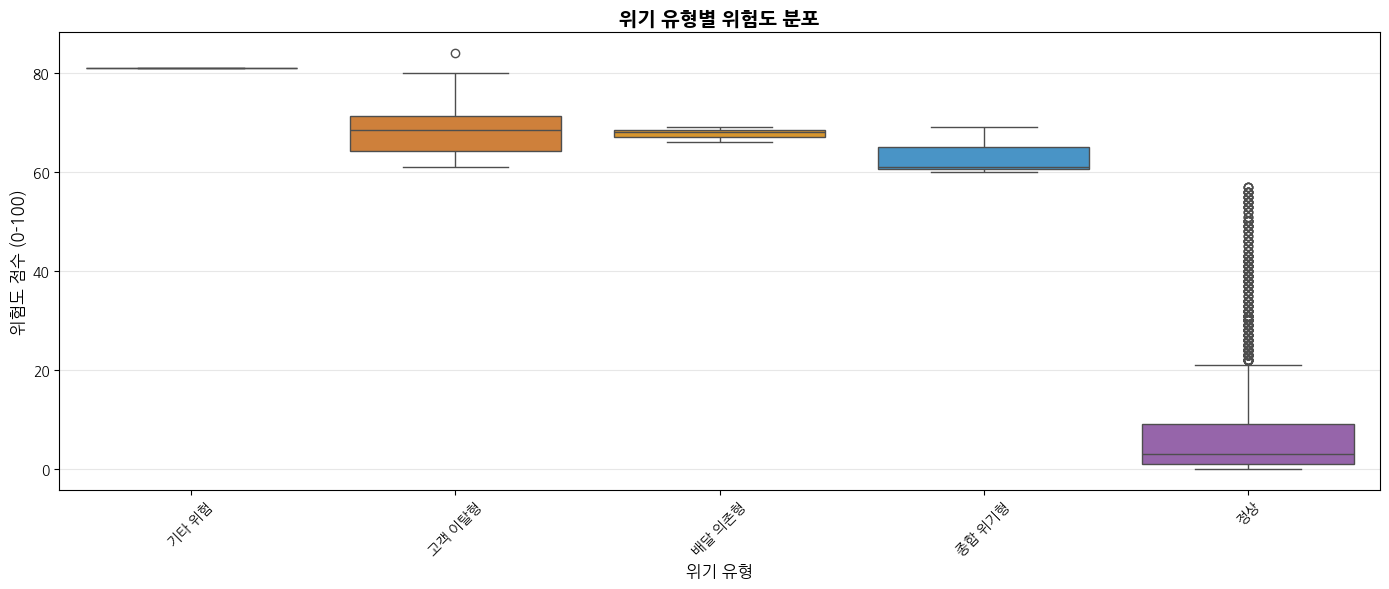

✅ Saved: ../results/risk_type_score_distribution.png


In [16]:
# 시각화 2: 유형별 위험도 분포 (Boxplot)
fig, ax = plt.subplots(figsize=(14, 6))

# 유형별 정렬 (평균 위험도 높은 순)
type_order = df_risk.groupby('risk_type')['risk_score'].mean().sort_values(ascending=False).index

sns.boxplot(data=df_risk, x='risk_type', y='risk_score', order=type_order,
            palette=colors[:len(type_order)], ax=ax)
ax.set_xlabel('위기 유형', fontsize=12)
ax.set_ylabel('위험도 점수 (0-100)', fontsize=12)
ax.set_title('위기 유형별 위험도 분포', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'risk_type_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {output_dir / 'risk_type_score_distribution.png'}")

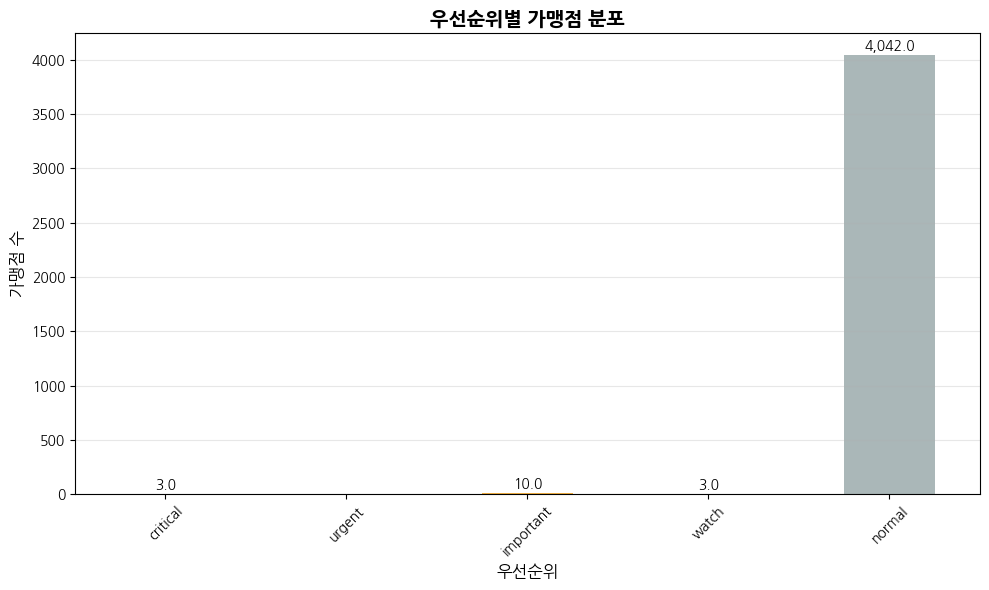

✅ Saved: ../results/priority_distribution.png


In [17]:
# 시각화 3: 우선순위별 분포
fig, ax = plt.subplots(figsize=(10, 6))

priority_counts = df_risk['priority'].value_counts().reindex(priority_order)
priority_colors = {'critical': '#e74c3c', 'urgent': '#e67e22', 'important': '#f39c12',
                  'watch': '#3498db', 'normal': '#95a5a6'}
colors_list = [priority_colors[p] for p in priority_order]

priority_counts.plot(kind='bar', ax=ax, color=colors_list, alpha=0.8)
ax.set_xlabel('우선순위', fontsize=12)
ax.set_ylabel('가맹점 수', fontsize=12)
ax.set_title('우선순위별 가맹점 분포', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(priority_counts):
    ax.text(i, v + 20, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(output_dir / 'priority_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {output_dir / 'priority_distribution.png'}")

## 9. 결과 저장

In [18]:
# 결과 저장 (output_dir은 이미 시각화 섹션에서 생성됨)

# 1. 전체 분류 결과 저장
df_risk_full = df_risk.sort_values('risk_score', ascending=False)
df_risk_full.to_csv(output_dir / 'risk_classification_results.csv', index=False, encoding='utf-8-sig')
print(f"✅ Saved: {output_dir / 'risk_classification_results.csv'}")
print(f"   Total merchants: {len(df_risk_full):,}")

# 2. 유형별 통계 저장
risk_type_statistics = {
    'summary': {
        'total_merchants': int(len(df_risk)),
        'prediction_date': str(latest_month),
        'risk_types': list(df_risk['risk_type'].unique())
    },
    'type_distribution': df_risk['risk_type'].value_counts().to_dict(),
    'priority_distribution': df_risk['priority'].value_counts().to_dict(),
    'type_statistics': {}
}

for risk_type in df_risk['risk_type'].unique():
    type_data = df_risk[df_risk['risk_type'] == risk_type]
    risk_type_statistics['type_statistics'][risk_type] = {
        'count': int(len(type_data)),
        'avg_risk_score': float(type_data['risk_score'].mean()),
        'median_risk_score': float(type_data['risk_score'].median()),
        'avg_closure_probability': float(type_data['closure_probability'].mean()),
        'avg_confidence': float(type_data['classification_confidence'].mean())
    }

with open(output_dir / 'risk_type_statistics.json', 'w', encoding='utf-8') as f:
    json.dump(risk_type_statistics, f, indent=2, ensure_ascii=False)
print(f"✅ Saved: {output_dir / 'risk_type_statistics.json'}")

# 3. 유형별 솔루션 저장
with open(output_dir / 'risk_type_solutions.json', 'w', encoding='utf-8') as f:
    json.dump(risk_solution_map, f, indent=2, ensure_ascii=False)
print(f"✅ Saved: {output_dir / 'risk_type_solutions.json'}")

# 4. 고위험 가맹점 리스트 (우선순위별)
high_risk_by_priority = {}
for priority in ['critical', 'urgent', 'important']:
    priority_merchants = df_risk[df_risk['priority'] == priority].sort_values('risk_score', ascending=False)
    high_risk_by_priority[priority] = priority_merchants[[
        'ENCODED_MCT', 'HPSN_MCT_BZN_CD_NM', 'risk_score', 'risk_type', 'classification_confidence'
    ]].head(50).to_dict('records')

with open(output_dir / 'high_risk_by_priority.json', 'w', encoding='utf-8') as f:
    json.dump(high_risk_by_priority, f, indent=2, ensure_ascii=False)
print(f"✅ Saved: {output_dir / 'high_risk_by_priority.json'}")

print("\n" + "=" * 80)
print("RISK CLASSIFICATION COMPLETED")
print("=" * 80)
print(f"\nTotal Active Merchants: {len(df_risk):,}")
print(f"\nRisk Type Distribution:")
for risk_type, count in df_risk['risk_type'].value_counts().items():
    pct = count / len(df_risk) * 100
    print(f"  {risk_type:20s}: {count:5,} ({pct:5.1f}%)")
print(f"\nHigh Risk Merchants:")
for priority in ['critical', 'urgent', 'important']:
    count = (df_risk['priority'] == priority).sum()
    print(f"  {priority:10s}: {count:5,}")
print(f"\nResults saved to: {output_dir}")

✅ Saved: ../results/risk_classification_results.csv
   Total merchants: 4,058
✅ Saved: ../results/risk_type_statistics.json
✅ Saved: ../results/risk_type_solutions.json
✅ Saved: ../results/high_risk_by_priority.json

RISK CLASSIFICATION COMPLETED

Total Active Merchants: 4,058

Risk Type Distribution:
  정상                  : 4,041 ( 99.6%)
  고객 이탈형              :    10 (  0.2%)
  배달 의존형              :     3 (  0.1%)
  종합 위기형              :     3 (  0.1%)
  기타 위험               :     1 (  0.0%)

High Risk Merchants:
  critical  :     3
  urgent    :     0
  important :    10

Results saved to: ../results


## 10. 결론

### 완료된 작업
- ✅ All Interval Features 모델로 폐업 위험도 예측
- ✅ 142개 Interval Pattern Features 기반 **5가지 위기 유형** 자동 분류
- ✅ 유형별 우선순위 부여 (critical/urgent/important/watch/normal)
- ✅ 유형별 맞춤형 솔루션 매칭
- ✅ 유형별 통계 분석 및 시각화
- ✅ 결과 저장 (CSV, JSON)

### 저장된 파일
1. `risk_classification_results.csv`: 전체 가맹점 위기 유형 분류 결과
2. `risk_type_statistics.json`: 유형별 통계 요약
3. `risk_type_solutions.json`: 유형별 맞춤형 솔루션 매핑
4. `high_risk_by_priority.json`: 우선순위별 고위험 가맹점 리스트
5. `risk_type_distribution.png`: 유형 분포 시각화
6. `risk_type_score_distribution.png`: 유형별 위험도 분포
7. `priority_distribution.png`: 우선순위별 분포

### 활용 방안
1. **맞춤형 개입**: 유형별로 최적화된 금융상품 및 지원 프로그램 제공
2. **우선순위 관리**: Critical/Urgent 가맹점에 리소스 집중 배분
3. **예방적 관리**: Watch 등급 가맹점 정기 모니터링으로 위기 예방
4. **성과 측정**: 개입 후 유형별 회복률 추적 및 전략 개선
5. **정책 수립**: 유형별 통계를 바탕으로 지역 상권 정책 수립